In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
import itertools as iter
import sys
#np.set_printoptions(threshold=sys.maxsize)
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper, LogarithmicMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp, commutator
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE, NumPyEigensolver
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ParameterVector
from qiskit.synthesis import SuzukiTrotter, LieTrotter, MatrixExponential


/home/ssr/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


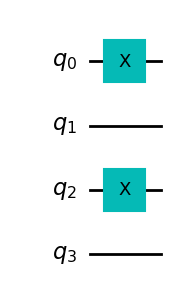

In [2]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')



In [23]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

PF_order = 2 # Order of Product Formula.
final_time = 100 # Termination time of real time evolution.
Trotter_Num = 10 # Trotter number associated with Product Formula construction.
time_step = 1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


In [24]:
estimator = Estimator()

Suzuki_energies = list()

for k in range(len(evo_time_range)):

        evo_prob = TimeEvolutionProblem(qubit_h2_Ham, evo_time_range[k], HartreeFock_initial) # Generate the initial Time Evolution problem.

        Suzuki = SuzukiTrotter(PF_order, Trotter_Num, True, "chain", None) # Invoke the Suzuki-Trotter formula.

        trotter_qrte = TrotterQRTE(product_formula=Suzuki, estimator=estimator, num_timesteps=Trotter_Num) # Invoke the Trotter Real Time Evolution Algorithm object.

        evolved_state = trotter_qrte.evolve(evo_prob).evolved_state

        result = estimator.run(evolved_state, qubit_h2_Ham, None).result()

        Suzuki_energies.append(np.real(result.values))

        evolved_instruction = evolved_state.to_instruction()

        evolved_vector = Statevector.from_instruction(evolved_instruction)


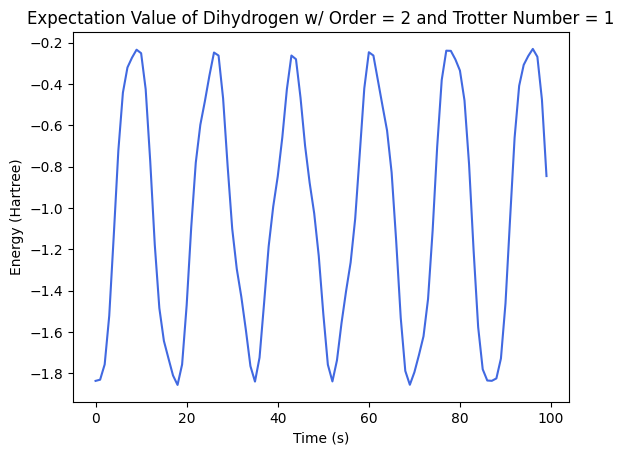

In [25]:
# Graph the energy variation over the specified time interval (in the case of a Suzuki-Trotter circuit):

plt.plot(evo_time_range, Suzuki_energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen w/ Order = " + str(PF_order) + " and Trotter Number = " + str(Trotter_Num))
plt.savefig('./Plots/Product Formulas/Expectation Values/h2_' + str(PF_order) + 'o_' + str(evo_time_range[-1]) + 's_' + str(Trotter_Num) + 'r.png')